# Predicting Opioid Mortality Rate - In Depth Analysis (Machine Learning)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import warnings
import collections
import scipy
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from joblib import Parallel, delayed
from itertools import islice

In [7]:
# suppress warnings
warnings.filterwarnings('ignore')

In [8]:
merged_remove = pd.read_csv('merged_remove.csv')

In [9]:
merged_remove['gq_%_of_total_pop'] = merged_remove['GQ Estimates 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [10]:
merged_remove['%_pop_chg'] = merged_remove['Population Change 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [11]:
merged_remove.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [12]:
y = merged_remove['Crude Opioid Mortality Rate (per 100,000)']
X = merged_remove.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

# Problem I want to solve

To predict opioid overdose mortality rate, I removed county population size estimate. I also converted the `GQ Estimates 2016 (count)` variable to percentage relative to population estimate. The reason for these is because these two variables were in absolute counts. Because they were in absolute counts, these variables caused the smaller counties to have predicted opioid overdose mortality rates of zero. This caused issues because just because the county had small population size did not mean that they would necessarily have zero opioid overdose mortality rate. Removing county population size and converting `GQ Estimates 2016 (count)` to percentages relative to county population size helped solve this problem.

The following is a list of all the variables used to predict county level opioid overdose mortality rate. The description of these variables can be found above.

<ol>
    <li>For a given regression prediction algorithm, do the following:</li>
    <li>%_pop_chg</li>
    <li>10_14_years_%</li>
    <li>15_19_years_%</li>
    <li>1_4_years_%</li>
    <li>20_24_years_%</li>
    <li>25_29_years_%</li>
    <li>30_34_years_%</li>
    <li>35_39_years_%</li>
    <li>40_44_years_%</li>
    <li>45_49_years_%</li>
    <li>50_54_years_%</li>
    <li>55_59_years_%</li>
    <li>5_9_years_%</li>
    <li>60_64_years_%</li>
    <li>65_69_years_%</li>
    <li>70_74_years_%</li>
    <li>75_79_years_%</li>
    <li>80_84_years_%</li>
    <li>85+_years_%</li>
    <li>All Other Death Rate 2016 (per 100,000)</li>
    <li>american_indian_or_alaska_native_%</li>
    <li>asian_or_pacific_islander_%</li>
    <li>Birth Rate 2016 (per 100)</li>
    <li>black_or_african_american_%</li>
    <li>Crude Opioid Mortality Rate (per 100,000)</li>
    <li>Domestic Migration Rate 2016 (per 100)</li>
    <li>gq_%_of_total_pop</li>
    <li>International Migration Rate 2016 (per 100)</li>
    <li>less_than_1_year_%</li>
    <li>Median Household Income 2016 (dollars)</li>
    <li>Opioid Prescription Rate (per 100)</li>
    <li>Percent with High School Diploma Only (%)</li>
    <li>Poverty Percentage 2016 (%)</li>
    <li>Unemployment Rate 2016 (per 100)</li>
    <li>white_%</li>
</ol>

The following eighteen algorithms were used to predict the county level opioid overdose mortality rates:

<ol>
    <li> Multiple Linear Regression </li>
    <li> Ridge Regression (Default Hyperparameters)  </li>
    <li> Ridge Regression (Tuned Hyperparameters) </li>
    <li> LASSO Regression (Default Hyperparameters)  </li>
    <li> LASSO Regression (Tuned Hyperparameters)  </li>
    <li> Elastic Net Regression (Default Hyperparameters)  </li>
    <li> Elastic Net Regression (Tuned Hyperparameters)  </li>
    <li> CART (Default Hyperparameters)  </li>
    <li> CART (Tuned Hyperparameters)  </li>
    <li> Random Forest Regression (Default Hyperparameters)  </li>
    <li> Random Forest Regression (Tuned Hyperparameters)  </li>
    <li> Gradient Boosting Regression (Default Hyperparameters)  </li>
    <li> Gradient Boosting Regression (Tuned Hyperparameters)  </li>
    <li> Stochastic Gradient Boosting (Default Hyperparameters, sklearn)  </li>
    <li> Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)  </li>
    <li> Stochastic Gradient Boosting (Default Hyperparameters, xgboost)  </li>
    <li> Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)  </li>
    <li> Hurdle Model (xgboost classification and regression)</li>
</ol>

For all of the algorithms, I used the same training set and test set. 80% of the data was randomly selected for the training set. The remaining 20% of the data was used for the test set.

When using default hyperparameters, the following procedure was performed:

<ol>
    <li>Use default hyperparameter values to fit data (no cross-validation was used)</li>
    <li>Calculate RMSE</li>
</ol>

When tuning for hyperparameters, the following procedure was performed:

<ol>
    <li>Tune hyperparameter values using RandomizedSearchCV (1000 iterations) and 5-fold cross-validation to fit the training set</li>
    <li>Select model that has the lowest RMSE</li>

Once the best models are selected, I created a bootstrap sampling distribution of the RMSE to obtain an estimate of the distribution of the RMSE and also to perform two-sample t tests to see if the differences between the models were statistically significant. The procedure for the bootstrapping is as follows:

<ol type="A">
    <li>From the dataset, sample counties with replacement 2369 times (80% of the data) to obtain the training set</li>
    <li>The rest of the data is the test set</li>
    <li>Fit the training set using the best models</li>
    <li>Make predictions for the test set</li>
    <li>Calculate RMSE</li>
    <li>Repeat steps one to five B = 10,000 times</li>
</ol>

# Road Map

1. PCA
3. Multiple Linear Regression
4. Linear Regression with Regularization
    * Ridge Regression
    * LASSO Regression
    * Elastic Net Regression
* CART
6. Random Forest Regression
7. Stochastic Gradient Boosting Regression
    * scikit-learn
    * xgboost

# Principal Component Analysis

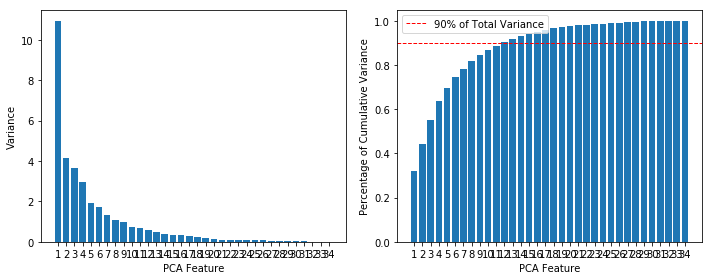

In [8]:
scaler = StandardScaler() # scale data to mean 0 and variance 1

pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

# Plot the explained variances
variance_by_pc = np.array(range(pca.n_components_)) + 1

f, (ax1 ,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

ax1.bar(variance_by_pc, pca.explained_variance_)
ax1.set_xlabel('PCA Feature')
ax1.set_ylabel('Variance')
ax1.set_xticks(ticks = variance_by_pc)

ax2.bar(variance_by_pc, np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('PCA Feature')
ax2.set_ylabel('Percentage of Cumulative Variance')
ax2.set_xticks(ticks = variance_by_pc)
ax2.axhline(y = 0.9, linestyle = 'dashed', linewidth=1, color='r', label = '90% of Total Variance')
ax2.legend()

f.tight_layout()
f.show()

In [9]:
pca_features = pipeline.transform(X)

In [10]:
pca_features.shape

(2962, 34)

In [11]:
%matplotlib inline

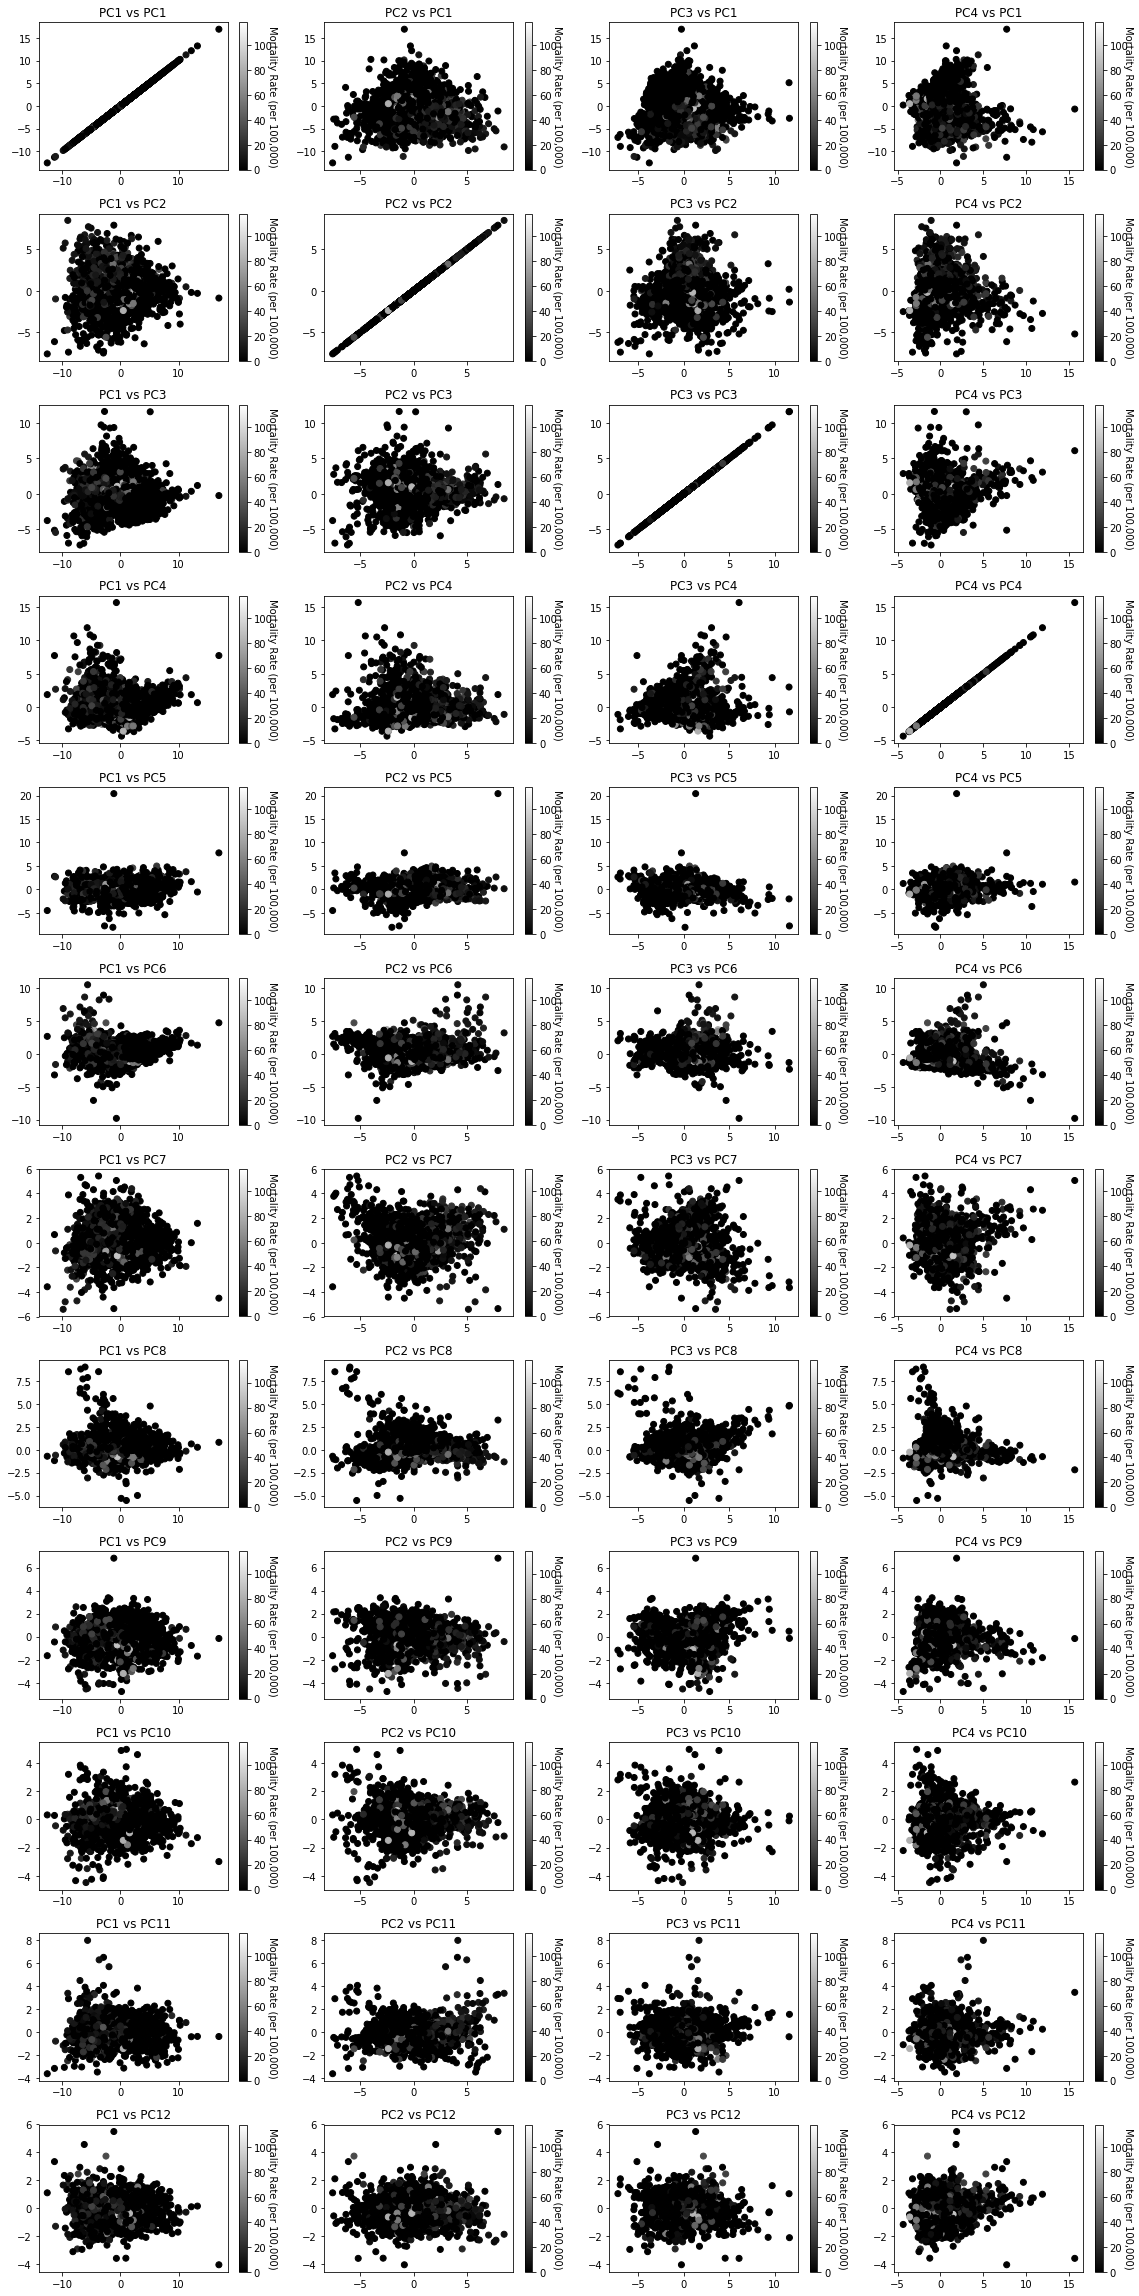

In [12]:
nrows, ncols = 12, 4

f, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (16, 32))

for i, ax in enumerate(axes):
    
    for j in range(ncols):
        
        pos = ax[j].scatter(x = pca_features[:, j], y = pca_features[:, i], c = y, cmap='gray')
        ax[j].set_title('PC{} vs PC{}'.format(j+1,i+1))
        cbar = f.colorbar(mappable = pos, ax = ax[j])
        cbar.set_label('Mortality Rate (per 100,000)', rotation = 270)

f.tight_layout()    
f.show()

In [13]:
# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [14]:
n_iter = 1000

In [15]:
def best_model_generator(fitted_model):
    """From the fitted model, returns the best model
       Also prints best hyperparameter values and test set rmse for fitted model"""
    # Extract the best hyperparameters from 'grid_elastic_net'
    best_hyperparams = fitted_model.best_params_

    print('Best hyperparameters:\n', best_hyperparams)

    # extract best model
    best_model = fitted_model.best_estimator_

    # predict the test set labels
    y_pred = best_model.predict(X_test)

    # Compute rmse_test
    rmse_test = MSE(y_test, y_pred)**0.5

    # Print rmse_test
    print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 
    
    # return best model
    return best_model

In [16]:
# # configure bootstrap using parallel for loop
# n_iterations = 1000
# # SEEDS = resample(range(1000), n_samples = n_iterations, random_state = SEED, replace = False)
# inputs = range(n_iterations)
# n_size = int(len(merged_remove) * 0.80)

# def bootstrap_rmse(i, model):
#     """Given model, function returns n_iterations of rmse from bootstrap sampling"""
#     train = resample(merged_remove, n_samples=n_size)
#     test_idx = [index for index in merged_remove.index if index not in train.index]
#     test = merged_remove.iloc[merged_remove.index.isin(test_idx), :]
#     # define X_train, y_train, X_test, y_test
#     X_train = train.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
#     y_train = train['Crude Opioid Mortality Rate (per 100,000)']
#     X_test = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
#     y_test = test['Crude Opioid Mortality Rate (per 100,000)']

#     model.fit(X_train, y_train)
#     # evaluate model
#     predictions = model.predict(X_test)
#     rmse = MSE(y_test, predictions)**0.5
#     return rmse

In [17]:
def plot_bootstrap_histogram(bootstrap_distribution, plot_label):
    """plots bootstrap histogram from bootstrap sampling and also prints 95% bootstrap CI values"""
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    sns.distplot(bootstrap_distribution, kde=False, rug=True, ax = ax)
    ax.set_title('Bootstrap Distribution of RMSE\n{}'.format(plot_label))
    fig.show()

In [18]:
def feature_importance_plot(model, plot_label):
    """Input is a model and plot label
       Output is a feature importance horizontal bar plot"""
    # create a pd.Series of features importances
    feature_importances = pd.Series(model.feature_importances_, index = X.columns)

    # sort feature_importances
    sorted_importances = feature_importances.sort_values()

    # make a horizontal bar plot
    f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 12))
    sorted_importances.plot(kind = 'barh', color = 'lightgreen', ax=ax)
    ax.set_title('Feature Importance Based on {}'.format(plot_label))
    f.show()

In [19]:
def fit_predict(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [20]:
def rmse_from_predictions(X_train, y_train, X_test, y_test, model):
    predictions = fit_predict(X_train, y_train, X_test, model)
    return MSE(y_test, predictions) ** 0.5

# Multiple Linear Regression

In [21]:
# Multiple Linear Regression

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('linear', LinearRegression())]

linear_pipeline = Pipeline(steps)

# fit to the training data
linear_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lr = linear_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_lr = MSE(y_test, y_pred_lr)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_lr)) 

Test RMSE of best model: 8.483


# Ridge Regression

## No hyperparameter tuning

In [22]:
# Ridge (no hyperparameter tuning)# Ridge  

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

ridge_pipeline = Pipeline(steps)

# fit to the training data
ridge_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_ridge = ridge_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_ridge = MSE(y_test, y_pred_ridge)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_ridge))

Test RMSE of best model: 8.479


# Ridge Regression

## Hyperparameter Tuning

In [23]:
# Ridge (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
ridge_pipeline = Pipeline(steps)

ridge_param_grid = dict(ridge__alpha= np.logspace(-10, 0, 500),
                        ridge__fit_intercept= [True, False])

ridge_randomized_neg_mse = RandomizedSearchCV(estimator = ridge_pipeline, 
                                 param_distributions = ridge_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_ridge' to the training data
ridge_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 3020 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3770 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4620 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123, solver='auto', tol=0.001))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'ridge__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'ridge__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [24]:
best_model_ridge = best_model_generator(fitted_model = ridge_randomized_neg_mse)

Best hyperparameters:
 {'ridge__fit_intercept': True, 'ridge__alpha': 1.0}
Test RMSE of best model: 8.479


# LASSO Regression
## No Hyperparameter Tuning

In [25]:
# LASSO (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

lasso_pipeline = Pipeline(steps)

# fit to the training data
lasso_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lasso = lasso_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_lasso = MSE(y_test, y_pred_lasso)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_lasso))

Test RMSE of best model: 9.024


# LASSO Regression

## Hyperparameter Tuning

In [26]:
# LASSO (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
lasso_pipeline = Pipeline(steps)

lasso_param_grid = dict(lasso__alpha= np.logspace(-10, 0, 500),
                        lasso__fit_intercept= [True, False])

lasso_randomized_neg_mse = RandomizedSearchCV(estimator = lasso_pipeline, 
                                 param_distributions = lasso_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_lasso' to the training data
lasso_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 2458 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 3208 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'lasso__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'lasso__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [27]:
best_model_lasso = best_model_generator(fitted_model = lasso_randomized_neg_mse)

Best hyperparameters:
 {'lasso__fit_intercept': True, 'lasso__alpha': 0.00946132375589076}
Test RMSE of best model: 8.468


# Elastic Net Regression
## No Hyperparameter Tuning

In [28]:
# Elastic Net (no hyperparameter tuning)# Elasti 

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('enet', ElasticNet(random_state = SEED))]

enet_pipeline = Pipeline(steps)

# fit to the training data
enet_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_enet = enet_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_enet = MSE(y_test, y_pred_enet)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_enet))

Test RMSE of best model: 8.829


# Elastic Net

## Hyperparameter Tuning

In [29]:
# Elastic Net (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('enet', ElasticNet(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
enet_pipeline = Pipeline(steps)

enet_param_grid = dict(enet__alpha= np.logspace(-10, 0, 500),
                              enet__l1_ratio = np.arange(0, 1, 0.01),
                              enet__fit_intercept= [True, False])

enet_randomized_neg_mse = RandomizedSearchCV(estimator = enet_pipeline, 
                                 param_distributions = enet_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_elastic_net' to the training data
enet_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 958 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1758 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 2308 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 2958 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 3708 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4558 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('enet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123, selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'enet__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'enet__l1_ratio': array([0.  , 0.01, ..., 0.98, 0.99]), 'enet__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [30]:
best_model_enet = best_model_generator(fitted_model = enet_randomized_neg_mse)

Best hyperparameters:
 {'enet__l1_ratio': 0.88, 'enet__fit_intercept': True, 'enet__alpha': 0.004958962013837212}
Test RMSE of best model: 8.473


# Classification and Regressor Tree (CART)
## No Hyperparameter Tuning

In [31]:
# CART (no hyperparameter tuning)

# Instantiate dt
dt = DecisionTreeRegressor(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred_dt = dt.predict(X_test)

# Compute MSE
rmse_test_dt = MSE(y_test, y_pred_dt) ** 0.5

# Print RMSE
print('Test set RMSE of dt: {:.3f}'.format(rmse_test_dt))

Test set RMSE of dt: 12.117


# Classification and Regressor Tree (CART)

## Hyperparameter Tuning

In [32]:
# CART (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('dt', DecisionTreeRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
dt_pipeline = Pipeline(steps)

dt_param_grid = dict(dt__max_depth= np.arange(1, 50, 10),
                     dt__min_samples_split= np.arange(2, 50, 2),
                     dt__min_samples_leaf= np.arange(1, 100, 2))

dt_randomized_neg_mse = RandomizedSearchCV(estimator = dt_pipeline, 
                                 param_distributions = dt_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_dt' to the training data
dt_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    4.4s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best'))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'dt__max_depth': array([ 1, 11, 21, 31, 41]), 'dt__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]), 'dt__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
          pre_dispatch='2*n_jobs', random_state=None, 

In [33]:
best_model_dt = best_model_generator(fitted_model = dt_randomized_neg_mse)

Best hyperparameters:
 {'dt__min_samples_split': 6, 'dt__min_samples_leaf': 89, 'dt__max_depth': 31}
Test RMSE of best model: 8.222


# Random Forest Regressor
## No Hyperparameter Tuning

In [34]:
#  random forest (no hyperparameter tuning)

# Instantiate rf
rf = RandomForestRegressor(random_state=SEED)

# Fit rf to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred_rf = rf.predict(X_test)

# Compute RMSE
rmse_test_rf = MSE(y_test, y_pred_rf)**0.5

# Print RMSE
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_rf))

Test set RMSE of rf: 8.805


# Random Forest Regressor

## Hyperparameter Tuning

In [35]:
# RandomForest (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('rf', RandomForestRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
rf_pipeline = Pipeline(steps)

rf_param_grid = dict(rf__n_estimators = np.arange(2, 500, 10),
                     rf__max_depth= np.arange(1, 50, 10),
                     rf__max_features= np.arange(0.05, 1, 0.05),
                     rf__min_samples_split= np.arange(2, 50, 2),
                     rf__min_samples_leaf= np.arange(1, 100, 2),
                     rf__bootstrap= [True, False])

rf_randomized_neg_mse = RandomizedSearchCV(estimator = rf_pipeline, 
                                 param_distributions = rf_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_rf' to the training data
rf_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'rf__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4...   69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]), 'rf__bootstrap': [True, False]},
          pre_dispatch='2*n_job

In [36]:
best_model_rf = best_model_generator(fitted_model = rf_randomized_neg_mse)

Best hyperparameters:
 {'rf__n_estimators': 222, 'rf__min_samples_split': 22, 'rf__min_samples_leaf': 11, 'rf__max_features': 0.25, 'rf__max_depth': 31, 'rf__bootstrap': False}
Test RMSE of best model: 7.493


# Feature Importance Based on Random Forest Best Model

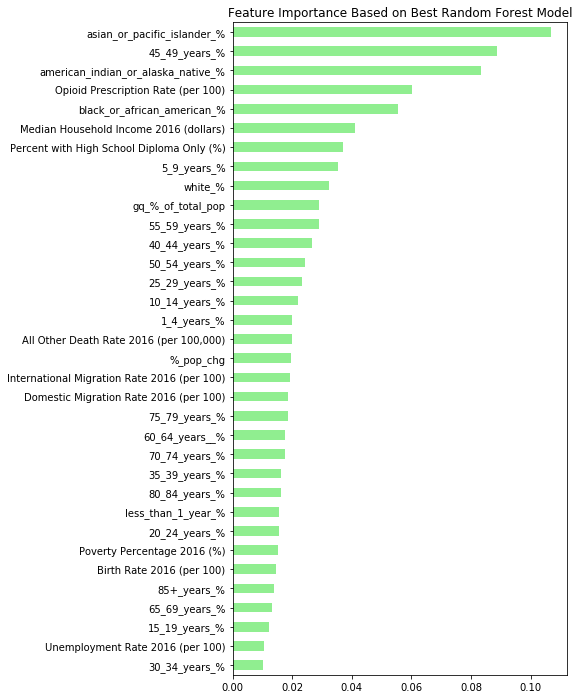

In [37]:
feature_importance_plot(best_model_rf.steps[0][1], 'Best Random Forest Model')

# Gradient Boosting Regressor

## No Hyperparameter Tuning

In [38]:
#  gradient boosting using scikit-learn (no hyperparameter tuning)

# Instantiate gb
gb = GradientBoostingRegressor(random_state=SEED)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred_gb = gb.predict(X_test)

# Compute RMSE
rmse_test_gb = MSE(y_test, y_pred_gb)**0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test_gb))

Test set RMSE of gb: 7.693


# Gradient Boosting Regressor

## Hyperparameter Tuning

In [39]:
# gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('gb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
gb_pipeline = Pipeline(steps)

gb_param_grid = dict(gb__n_estimators = np.arange(2, 500, 10),
                      gb__max_depth= np.arange(1, 50, 10),
                      gb__min_samples_split= np.arange(2, 50, 2),
                      gb__min_samples_leaf= np.arange(1, 100, 2),
                      gb__learning_rate = np.arange(0.05, 1, 0.05))

gb_randomized_neg_mse = RandomizedSearchCV(estimator = gb_pipeline, 
                                            param_distributions = gb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = n_iter,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_gb' to the training data
gb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  8.8min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, m...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'gb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tru

In [40]:
best_model_gb = best_model_generator(fitted_model = gb_randomized_neg_mse)

Best hyperparameters:
 {'gb__n_estimators': 162, 'gb__min_samples_split': 22, 'gb__min_samples_leaf': 97, 'gb__max_depth': 11, 'gb__learning_rate': 0.05}
Test RMSE of best model: 7.700


# Stochastic Gradient Boosting Regressor (scikit-learn)

## No Hyperparameter Tuning

In [41]:
# stochastic gradient boosting regressor using scikit-learn (no parameter tuning)

# Instantiate sgbr
sgbr = GradientBoostingRegressor(subsample=0.9,
            max_features=0.75,
            random_state=SEED)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_sgbr = sgbr.predict(X_test)

# Compute test set RMSE
rmse_test_sgbr = MSE(y_test, y_pred_sgbr)**0.5


# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test_sgbr))

Test set RMSE of sgbr: 7.700


# Stochastic Gradient Boosting Regressor (scikit-learn)

## Hyperparameter Tuning

In [42]:
# stochastic gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('sgb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
sgb_pipeline = Pipeline(steps)

sgb_param_grid = dict(sgb__n_estimators = np.arange(2, 500, 10),
                      sgb__max_depth= np.arange(1, 50, 10),
                      sgb__max_features= np.arange(0.05, 1, 0.05),
                      sgb__min_samples_split= np.arange(2, 50, 2),
                      sgb__min_samples_leaf= np.arange(1, 100, 2),
                      sgb__subsample= np.arange(0.05, 1, 0.05),
                      sgb__learning_rate = np.arange(0.05, 1, 0.05))

sgb_randomized_neg_mse = RandomizedSearchCV(estimator = sgb_pipeline, 
                                            param_distributions = sgb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = n_iter,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_sgb' to the training data
sgb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('sgb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, ...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'sgb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, ..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tru

In [43]:
best_model_sgb = best_model_generator(fitted_model = sgb_randomized_neg_mse)

Best hyperparameters:
 {'sgb__subsample': 0.9000000000000001, 'sgb__n_estimators': 332, 'sgb__min_samples_split': 10, 'sgb__min_samples_leaf': 75, 'sgb__max_features': 0.35000000000000003, 'sgb__max_depth': 41, 'sgb__learning_rate': 0.05}
Test RMSE of best model: 7.857


# Stochastic Gradient Boosting Regressor (xgboost)

## No Hyperparameter Tuning

In [44]:
# stochastic gradient boosting regressor using xgboost (no parameter tuning)

# Instantiate xgbr
xgbr = xgb.XGBRegressor(subsample=0.9,
            colsample_bytree=0.75,
            random_state=SEED)

# Fit xgbr to the training set
xgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_xgbr = xgbr.predict(X_test)

# Compute test set RMSE
rmse_test_xgbr = MSE(y_test, y_pred_xgbr)**0.5

# Print rmse_test
print('Test set RMSE of xgbr: {:.3f}'.format(rmse_test_xgbr))

Test set RMSE of xgbr: 7.643


# Feature Importance Based on XGBoost

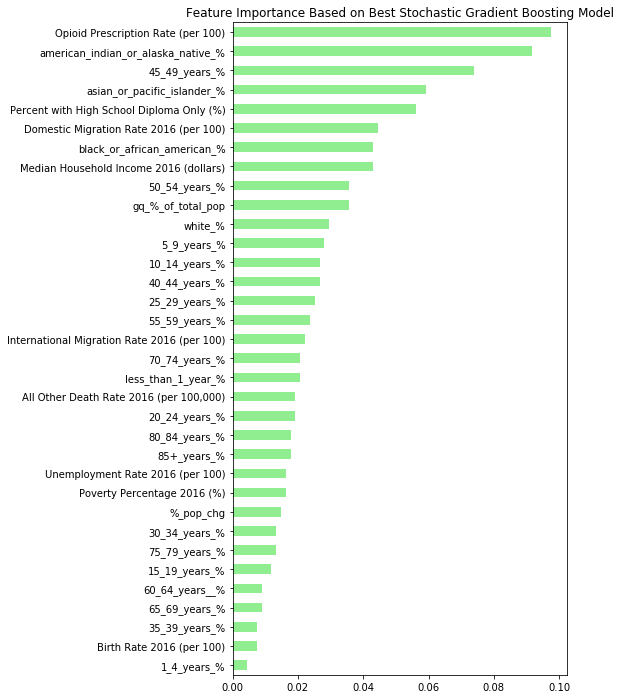

In [45]:
feature_importance_plot(xgbr, 'Best Stochastic Gradient Boosting Model')

# Stochastic Gradient Boosting Regressor (xgboost)

## Hyperparameter Tuning

In [46]:
# Stochastic Gradient Boosting Regressor using xgbroost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 831 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1225 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 2235 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2885 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3635 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4485 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('xgbr', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'xgbr__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452,..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n

In [47]:
best_model_xgbr = best_model_generator(fitted_model = xgbr_randomized_neg_mse)

Best hyperparameters:
 {'xgbr__subsample': 0.8500000000000001, 'xgbr__n_estimators': 362, 'xgbr__max_depth': 12, 'xgbr__learning_rate': 0.05, 'xgbr__colsample_bytree': 0.55}
Test RMSE of best model: 7.719


# Hurdle Model

In [48]:
merged_remove_hurdle = pd.read_csv('merged_remove.csv')

merged_remove_hurdle['classification'] = np.where(merged_remove_hurdle['Crude Opioid Mortality Rate (per 100,000)'] == 0, 0, 1)

merged_remove_hurdle['gq_%_of_total_pop'] = merged_remove_hurdle['GQ Estimates 2016 (count)'] / \
                                     merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

merged_remove_hurdle['%_pop_chg'] = merged_remove_hurdle['Population Change 2016 (count)'] / \
                                     merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

merged_remove_hurdle.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [49]:
y_hurdle = merged_remove_hurdle['classification']
X_hurdle = merged_remove_hurdle.drop(columns = ['classification', 'Crude Opioid Mortality Rate (per 100,000)'])

# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train_hurdle_clf, X_test_hurdle_clf, y_train_hurdle_clf, y_test_hurdle_clf = train_test_split(X_hurdle, y_hurdle, 
                                                            test_size = 0.2, stratify = y_hurdle, random_state = SEED)

X_train_hurdle_clf.sort_index(inplace = True)

X_test_hurdle_clf.sort_index(inplace = True)

y_train_hurdle_clf.sort_index(inplace = True)

y_test_hurdle_clf.sort_index(inplace = True)

In [50]:
# Stochastic Gradient Boosting Classifier using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbc', xgb.XGBClassifier(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbc_pipeline = Pipeline(steps)

xgbc_param_grid = dict(xgbc__n_estimators = np.arange(2, 500, 10),
                      xgbc__max_depth= np.arange(1, 50, 1),
                      xgbc__subsample= np.arange(0.05, 1, 0.05),
                      xgbc__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbc__learning_rate = np.arange(0.05, 1, 0.05))

xgbc_randomized_recall = RandomizedSearchCV(estimator = xgbc_pipeline, 
                                 param_distributions = xgbc_param_grid, 
                                 scoring = 'recall', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'xgbc_randomized_recall' to the training data
xgbc_randomized_recall.fit(X_train_hurdle_clf, y_train_hurdle_clf)

# Extract the best hyperparameters from 'grid_xgbc'
best_hyperparams_clf = xgbc_randomized_recall.best_params_

print('Best hyperparameters:\n', best_hyperparams_clf)

# extract best model from 'grid_xgbc'
best_model_xgbc_hurdle = xgbc_randomized_recall.best_estimator_

recall_score(y_test_hurdle_clf, best_model_xgbc_hurdle.predict(X_test_hurdle_clf))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


Best hyperparameters:
 {'xgbc__subsample': 0.05, 'xgbc__n_estimators': 352, 'xgbc__max_depth': 47, 'xgbc__learning_rate': 0.8500000000000001, 'xgbc__colsample_bytree': 0.7000000000000001}


0.7

In [51]:
predictions_best_model_train = best_model_xgbc_hurdle.predict(X_train_hurdle_clf)

X_train_hurdle_reg = X_train_hurdle_clf[predictions_best_model_train == 1].sort_index()

y_train_hurdle_reg = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_train_hurdle_reg.index),\
                                               merged_remove_hurdle.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')]\
                                               .sort_index()

In [52]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train_hurdle_reg, y_train_hurdle_reg)

# Extract the best hyperparameters from 'grid_xgbr'
best_hyperparams_reg = xgbr_randomized_neg_mse.best_params_

print('Best hyperparameters:\n', best_hyperparams_reg)

# extract best model from 'grid_xgbr'
best_model_xgbr_hurdle = xgbr_randomized_neg_mse.best_estimator_

predictions_best_model_test = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

X_test_hurdle_reg = X_test_hurdle_clf[predictions_best_model_test == 1].sort_index()

y_test_hurdle_reg = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_test_hurdle_reg.index),\
                                              merged_remove_hurdle.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')]\
                                              .sort_index()

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2533 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3183 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 3933 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 4783 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   28.3s finished


Best hyperparameters:
 {'xgbr__subsample': 0.4, 'xgbr__n_estimators': 212, 'xgbr__max_depth': 34, 'xgbr__learning_rate': 0.05, 'xgbr__colsample_bytree': 0.35000000000000003}


In [53]:
# predict the test set labels
y_pred_hurdle_reg = best_model_xgbr_hurdle.predict(X_test_hurdle_reg)

# Compute rmse_test
rmse_test_hurdle = MSE(y_test_hurdle_reg, y_pred_hurdle_reg)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_hurdle)) 

Test RMSE of best model: 11.103


In [54]:
# overall test set rmse

In [55]:
test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_test_hurdle_clf.index), :].sort_index()

test['class_prediction'] = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

test['clf_reg_prediction'] = test['class_prediction']

test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                              'classification', 
                                              'class_prediction', 
                                              'clf_reg_prediction'])

test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                            best_model_xgbr_hurdle.predict(test_no_mortality_rate[test.class_prediction == 1])

score = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5
print(score)

8.489317459343749


In [56]:
def hurdle_bootstrap_rmse(train_index, test_index):
        # hurdle approach
    train = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(train_index), :].sort_index()
    test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(test_index), :].sort_index()

    # define X_train_hurdle_clf, y_train_hurdle_clf, X_test_hurdle_clf, y_test_hurdle_clf
    X_train_hurdle_clf = train.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_train_hurdle_clf = train.classification

    X_test_hurdle_clf = test.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_test_hurdle_clf = test.classification

    best_model_xgbc_hurdle.fit(X_train_hurdle_clf, y_train_hurdle_clf)    


    predictions_best_model_train = best_model_xgbc_hurdle.predict(X_train_hurdle_clf)

    X_train_hurdle_reg = X_train_hurdle_clf[predictions_best_model_train == 1].sort_index()

    y_train_hurdle_reg = train.iloc[train.index.isin(X_train_hurdle_reg.index), 
                                    train.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')].sort_index()


    predictions_best_model_test = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

    X_test_hurdle_reg = X_test_hurdle_clf[predictions_best_model_test == 1].sort_index()

    y_test_hurdle_reg = test.iloc[test.index.isin(X_test_hurdle_reg.index), 
                                  test.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')].sort_index()


    best_model_xgbr_hurdle.fit(X_train_hurdle_reg, y_train_hurdle_reg)


    # evaluate model
    test['class_prediction'] = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

    test['clf_reg_prediction'] = test['class_prediction']

    test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                  'classification', 
                                                  'class_prediction', 
                                                  'clf_reg_prediction'])

    test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                                best_model_xgbr_hurdle.predict(test_no_mortality_rate[test.class_prediction == 1])

    rmse = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5

    return rmse

In [17]:
# configure bootstrap using parallel for loop
n_iterations = 10000
inputs = range(n_iterations)
n_size = int(len(merged_remove) * 0.80)

In [18]:
n_size

2369

In [57]:
def bootstrap_rmse_all_methods(iteration):
    # for i in range(n_iterations):
    """Given model, function returns n_iterations of rmse from bootstrap sampling"""
    train = resample(merged_remove, n_samples=n_size).sort_index()
    train_index = train.index
    test_idx = [index for index in merged_remove.index if index not in train.index]
    test = merged_remove.iloc[merged_remove.index.isin(test_idx), :].sort_index()
    # define X_train, y_train, X_test, y_test
    X_train = train.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_train = train['Crude Opioid Mortality Rate (per 100,000)']
    X_test = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_test = test['Crude Opioid Mortality Rate (per 100,000)']

    rmse = []

    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, linear_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, ridge_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_ridge))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, lasso_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_lasso))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, enet_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_enet))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, dt))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_dt))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, rf))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_rf))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, gb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_gb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, sgbr))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_sgb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, xgbr))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_xgbr))
    rmse.append(hurdle_bootstrap_rmse(train_index = train.index, test_index = test_idx))
#     print(rmse)
    return rmse

In [58]:
bootstrap_rmse_df = pd.DataFrame(Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse_all_methods)(i) for i in inputs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 8354 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 60.6min finished


# Boxplot of Bootstrap Distributions for All Methods

In [59]:
bootstrap_rmse_df.columns = ['Multiple Linear Regression',
                              'Ridge Regression (Default Hyperparameters)', 
                              'Ridge Regression (Tuned Hyperparameters)' , 
                              'LASSO Regression (Default Hyperparameters)', 
                              'LASSO Regression (Tuned Hyperparameters)', 
                              'Elastic Net Regression (Default Hyperparameters)', 
                              'Elastic Net Regression (Tuned Hyperparameters)', 
                              'CART (Default Hyperparameters)', 
                              'CART (Tuned Hyperparameters)', 
                              'Random Forest Regression (Default Hyperparameters)', 
                              'Random Forest Regression (Tuned Hyperparameters)', 
                              'Gradient Boosting Regression (Default Hyperparameters)', 
                              'Gradient Boosting Regression (Tuned Hyperparameters)', 
                              'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)', 
                              'Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)', 
                              'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)', 
                              'Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)', 
                              'Hurdle Model (xgboost classification and regression)']

In [60]:
# reorder columns by median
bootstrap_rmse_df_reordered = bootstrap_rmse_df.reindex_axis(bootstrap_rmse_df.median().\
                                                             sort_values(ascending = False).index, axis=1)

In [27]:
bootstrap_rmse_df_reordered.columns = ['CART (Default Hyperparameters)',
       'LASSO Regression (Default Hyperparameters)',
       'Hurdle Model (xgboost classification and regression)',
       'Elastic Net Regression (Default Hyperparameters)',
       'Random Forest Regression (Default Hyperparameters)',
       'CART (Tuned Hyperparameters)', 'Multiple Linear Regression',
       'Ridge Regression (Tuned Hyperparameters)',
       'Ridge Regression (Default Hyperparameters)',
       'Elastic Net Regression (Tuned Hyperparameters)',
       'LASSO Regression (Tuned Hyperparameters)',
       'Gradient Boosting Regression (Default Hyperparameters)',
       'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)',
       'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)',
       'Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)',
       'Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)',
       'Gradient Boosting Regression (Tuned Hyperparameters)',
       'Random Forest Regression (Tuned Hyperparameters)']

In [29]:
bootstrap_rmse_df_reordered.to_csv('bootstrap_rmse_df_reordered.csv', index = False)

# Hypothesis Testing

In [30]:
bootstrap_rmse_df_reordered = pd.read_csv('bootstrap_rmse_df_reordered.csv')

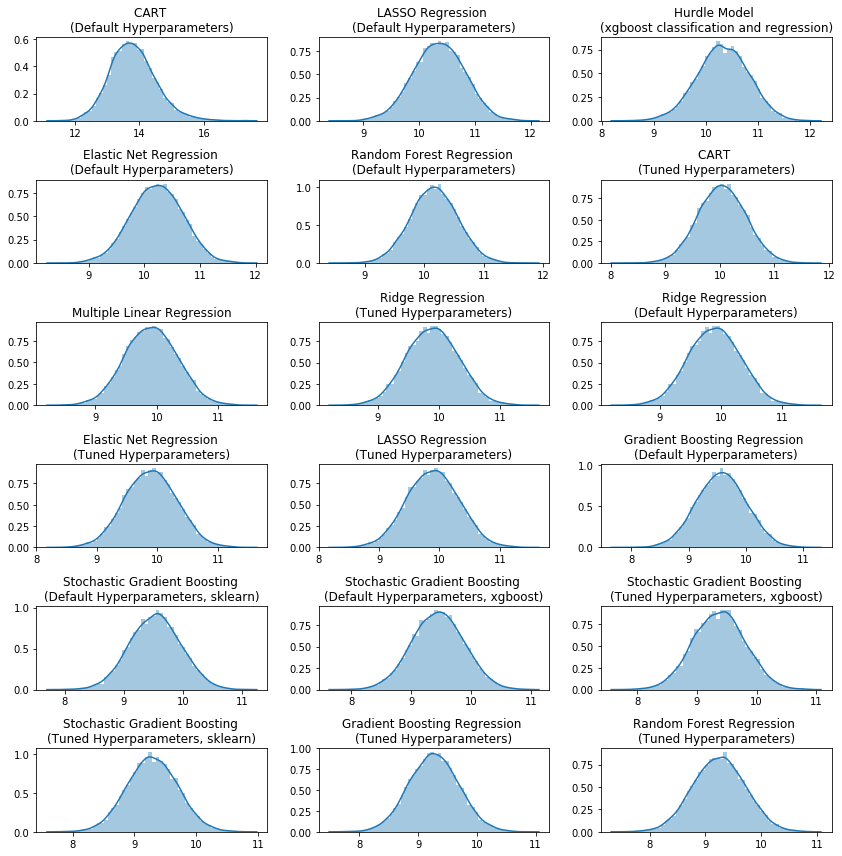

In [31]:
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 12))

for i, ax in enumerate(axes.flatten()):
    _ = sns.distplot(bootstrap_rmse_df_reordered.iloc[:, i], ax = ax)
    plot_title = bootstrap_rmse_df_reordered.columns[i]
    if '(' in plot_title:
        plot_title = plot_title.split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]))
    else:
        _ = ax.set_title('{}'.format(plot_title))
    _ = ax.set_xlabel('')

fig.tight_layout()
fig.savefig('images/bootstrap_hist_all_models.png')
fig.show()

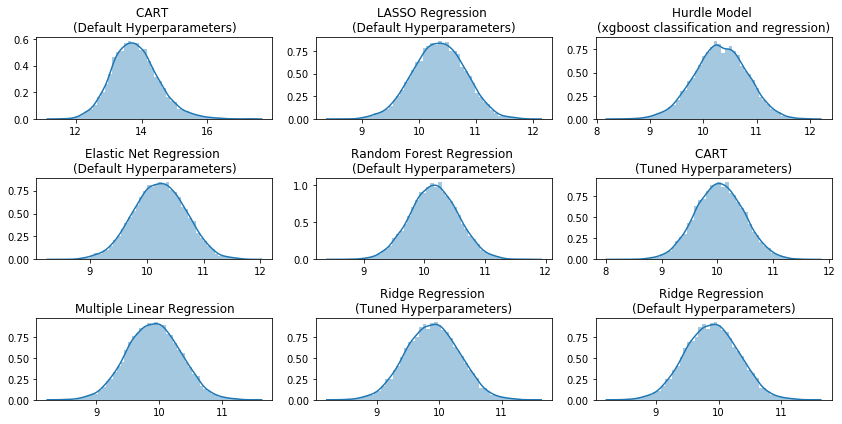

In [32]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 6))

for i, ax in enumerate(axes.flatten()):
    _ = sns.distplot(bootstrap_rmse_df_reordered.iloc[:, i], ax = ax)
    plot_title = bootstrap_rmse_df_reordered.columns[i]
    if '(' in plot_title:
        plot_title = plot_title.split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]))
    else:
        _ = ax.set_title('{}'.format(plot_title))
    _ = ax.set_xlabel('')

fig.tight_layout()
fig.savefig('images/bootstrap_hist_1.png')
fig.show()

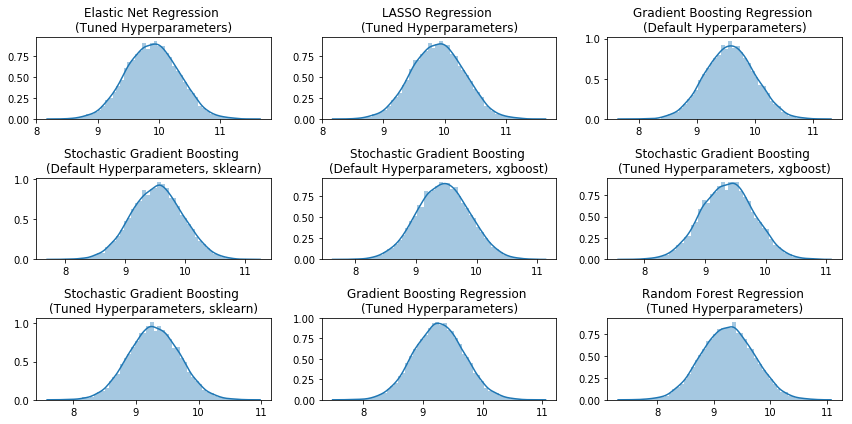

In [33]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 6))

for i, ax in enumerate(axes.flatten()):
    _ = sns.distplot(bootstrap_rmse_df_reordered.iloc[:, i + 9], ax = ax)
    plot_title = bootstrap_rmse_df_reordered.columns[i + 9]
    if '(' in plot_title:
        plot_title = plot_title.split('(')
    _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]))
    _ = ax.set_xlabel('')

fig.tight_layout()
fig.savefig('images/bootstrap_hist_2.png')
fig.show()

In [34]:
# reorder columns by median
bootstrap_rmse_df_reverse = bootstrap_rmse_df_reordered.reindex_axis(bootstrap_rmse_df_reordered.median().\
                                                                     sort_values(ascending = True).index, axis=1)

In [35]:
np.mean(bootstrap_rmse_df_reverse.iloc[:, 0])

9.246495818819469

In [36]:
np.mean(bootstrap_rmse_df_reverse.iloc[:, 3])

9.374668988706444

In [37]:
np.mean(bootstrap_rmse_df_reverse.iloc[:, 0]) - np.mean(bootstrap_rmse_df_reverse.iloc[:, 3])

-0.1281731698869759

In [38]:
# create series for bootstrap distribution for the model with the lowest bootstrap median value
best_model_bootstrap_dist = bootstrap_rmse_df_reverse.iloc[:, 0]

# list to store t-test p-values
t_test_p_values = pd.DataFrame(columns = ['Model 1', 'Model 2', 'p-value'])

for i, col in enumerate(islice(bootstrap_rmse_df_reverse.columns, 1, None)):

    bootstrap_dist_model_i = bootstrap_rmse_df_reverse.iloc[:, bootstrap_rmse_df_reverse.columns.get_loc(col)]
    # equal variance f-test
    F = np.var(best_model_bootstrap_dist) / np.var(bootstrap_dist_model_i) # f-statistic
    df1 = len(best_model_bootstrap_dist) - 1 # degrees of freedom 1
    df1 = len(bootstrap_dist_model_i) - 1 # degrees of freedom 1
    p_value = scipy.stats.f.cdf(F, df1, df1) # p-value
    p_value
    if p_value > 0.05:
    # two-sample t-test
        results = (scipy.stats.ttest_ind(best_model_bootstrap_dist,\
                                         bootstrap_dist_model_i, equal_var = True))

    else:
        results = (scipy.stats.ttest_ind(best_model_bootstrap_dist,\
                                         bootstrap_dist_model_i, equal_var = False))
        
    t_test_p_values.loc[i] = [best_model_bootstrap_dist.name, bootstrap_dist_model_i.name, results[1]]

In [39]:
t_test_p_values

,Model 1,Model 2,p-value
0,Random Forest Regression (Tuned Hyperparameters),Gradient Boosting Regression (Tuned Hyperparam...,9.307487e-05
1,Random Forest Regression (Tuned Hyperparameters),Stochastic Gradient Boosting (Tuned Hyperparam...,4.117637e-13
2,Random Forest Regression (Tuned Hyperparameters),Stochastic Gradient Boosting (Tuned Hyperparam...,2.063396e-89
3,Random Forest Regression (Tuned Hyperparameters),Stochastic Gradient Boosting (Default Hyperpar...,3.593946e-221
4,Random Forest Regression (Tuned Hyperparameters),Stochastic Gradient Boosting (Default Hyperpar...,0.000000e+00
5,Random Forest Regression (Tuned Hyperparameters),Gradient Boosting Regression (Default Hyperpar...,0.000000e+00
6,Random Forest Regression (Tuned Hyperparameters),LASSO Regression (Tuned Hyperparameters),0.000000e+00
7,Random Forest Regression (Tuned Hyperparameters),Elastic Net Regression (Tuned Hyperparameters),0.000000e+00
8,Random Forest Regression (Tuned Hyperparameters),Ridge Regression (Default Hyperparameters),0.000000e+00
9,Random Forest Regression (Tuned Hyperparameters),Ridge Regression (Tuned Hyperparameters),0.000000e+00


In [40]:
t_test_p_values.to_csv('t_test_p_values.csv', index = False)

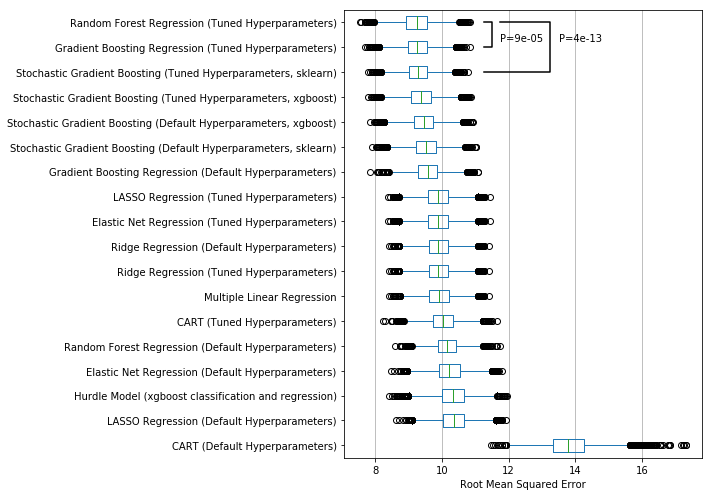

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))

_ = bootstrap_rmse_df_reordered.boxplot(vert = False, ax = ax)
_ = ax.yaxis.grid(False)
# _ = ax.set_title('Boxplot of Bootstrap RMSE Distributions for All Methods')
_ = ax.set_xlabel('Root Mean Squared Error')

# significance between first two models
x, h, col = bootstrap_rmse_df_reordered.iloc[0].max() + 2, 2, 'k'
ax.plot([11.25, 11.5, 11.5, 11.25], [18, 18, 17, 17], lw=1.5, c=col)
ax.text(11.75, 17.25, "P={}".format(round(t_test_p_values.iloc[0, 2], 5)), color=col)

# significance between first and third model
x, h, col = bootstrap_rmse_df_reordered.iloc[0].max() + 2, 2, 'k'
ax.plot([11.75, 13.25, 13.25, 11.25], [18, 18, 16, 16], lw=1.5, c=col)
ax.text(13.5, 17.25, "P={}".format(round(t_test_p_values.iloc[1, 2], 13)), color=col)

fig.tight_layout()
fig.savefig('images/boxplot_bootstrap_dist.png')
fig.show()

# Predict Opioid Overdose Mortality Rate for All Counties Using Best Model

In [63]:
# overall predictions for hurdle model
merged_remove_hurdle_no_classification_rate = merged_remove_hurdle.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                                                   'classification'])

merged_remove_hurdle['class_prediction'] = best_model_xgbc_hurdle.predict(merged_remove_hurdle_no_classification_rate)

merged_remove_hurdle['clf_reg_prediction'] = merged_remove_hurdle['class_prediction']

merged_remove_hurdle_no_mortality_rate = merged_remove_hurdle.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                                              'classification',
                                                                              'class_prediction',
                                                                              'clf_reg_prediction'])

merged_remove_hurdle.loc[merged_remove_hurdle.class_prediction == 1, 'clf_reg_prediction'] = \
                            best_model_xgbr_hurdle.predict(merged_remove_hurdle_no_mortality_rate\
                                                           [merged_remove_hurdle.class_prediction == 1])

In [64]:
predictions_df = pd.DataFrame(
    {'Multiple Linear Regression' : fit_predict(X_train, y_train, X, linear_pipeline),                  
     'Ridge Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, ridge_pipeline),
   'Ridge Regression (Tuned Hyperparameters)' : fit_predict(X_train, y_train, X, best_model_ridge),
   'LASSO Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, lasso_pipeline),
   'LASSO Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_lasso),
   'Elastic Net Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, enet_pipeline),
   'Elastic Net Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_enet),
   'CART (Default Hyperparameters)': fit_predict(X_train, y_train, X, dt),
   'CART (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_dt),
   'Random Forest Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, rf),
   'Random Forest Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_rf),
   'Gradient Boosting Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, gb),
   'Gradient Boosting Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_gb),
   'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)': fit_predict(X_train, y_train, X, sgbr),
   'Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)': fit_predict(X_train, y_train, X, best_model_sgb),
   'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)': fit_predict(X_train, y_train, X, xgbr),
   'Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)': fit_predict(X_train, y_train, X, best_model_xgbr),
   'Hurdle Model (xgboost classification and regression)': merged_remove_hurdle.clf_reg_prediction})

In [66]:
predictions_df_reordered = predictions_df[bootstrap_rmse_df_reverse.columns]

In [45]:
predictions_df_reordered.to_csv('predictions_df_reordered.csv', index = False)

In [46]:
predictions_df_reordered = pd.read_csv('predictions_df_reordered.csv')

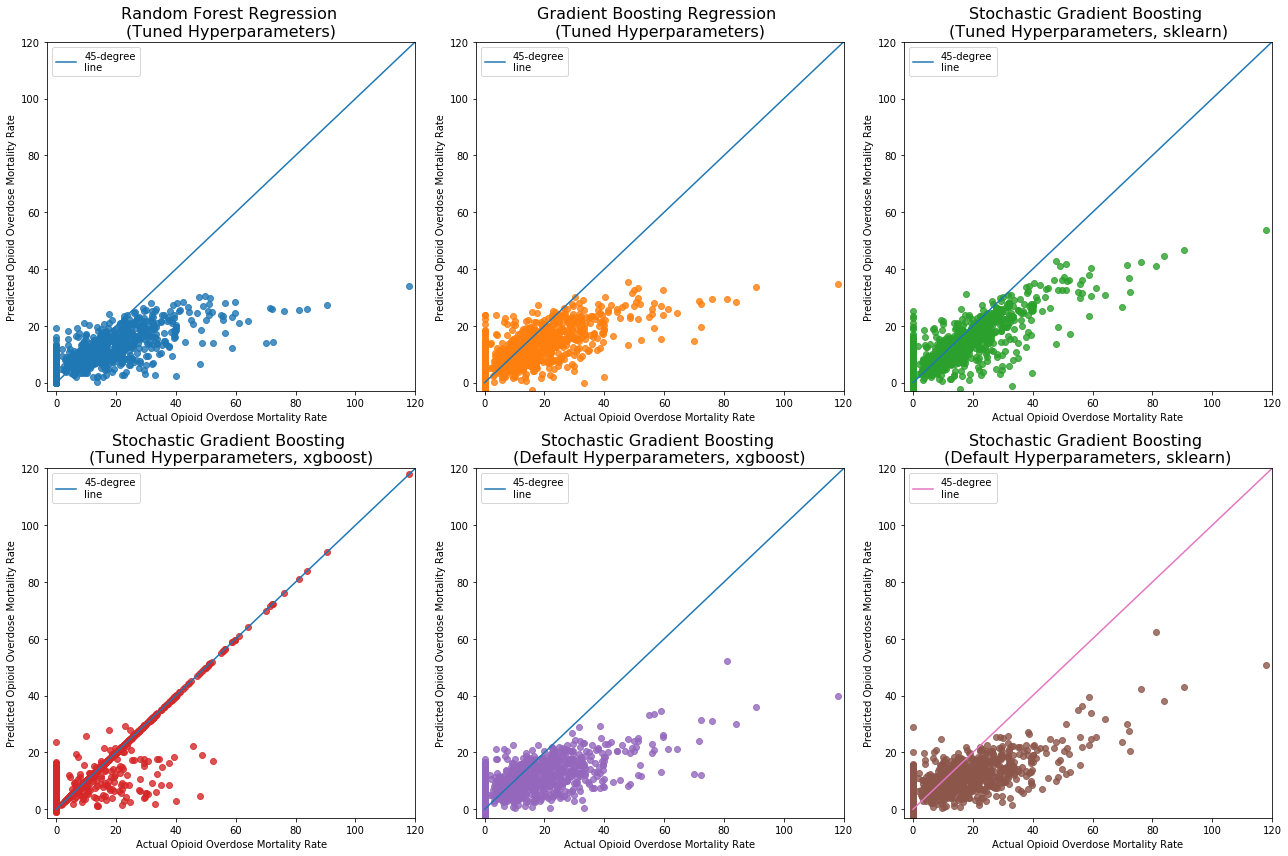

In [51]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 12))

for i, ax in enumerate(axes.flatten()):

    _ = sns.regplot(y = predictions_df_reordered.iloc[:, i], x = y, fit_reg = False, ax = ax)
    _ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
    _ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
    if '(' in predictions_df_reordered.columns[i]:
        plot_title = predictions_df_reordered.columns[i].split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]), fontsize = 16)
    else:
        plot_title = predictions_df_reordered.columns[i]
        _ = ax.set_title('{}'.format(plot_title), fontsize = 16)
    _ = ax.plot([0, 120], [0, 120]) # 45 degree line
    _ = ax.legend(['45-degree\nline'], frameon = True)
    _ = ax.set_xlim((-3, 120))
    _ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/predicted_actual_regression.png')
fig.show()

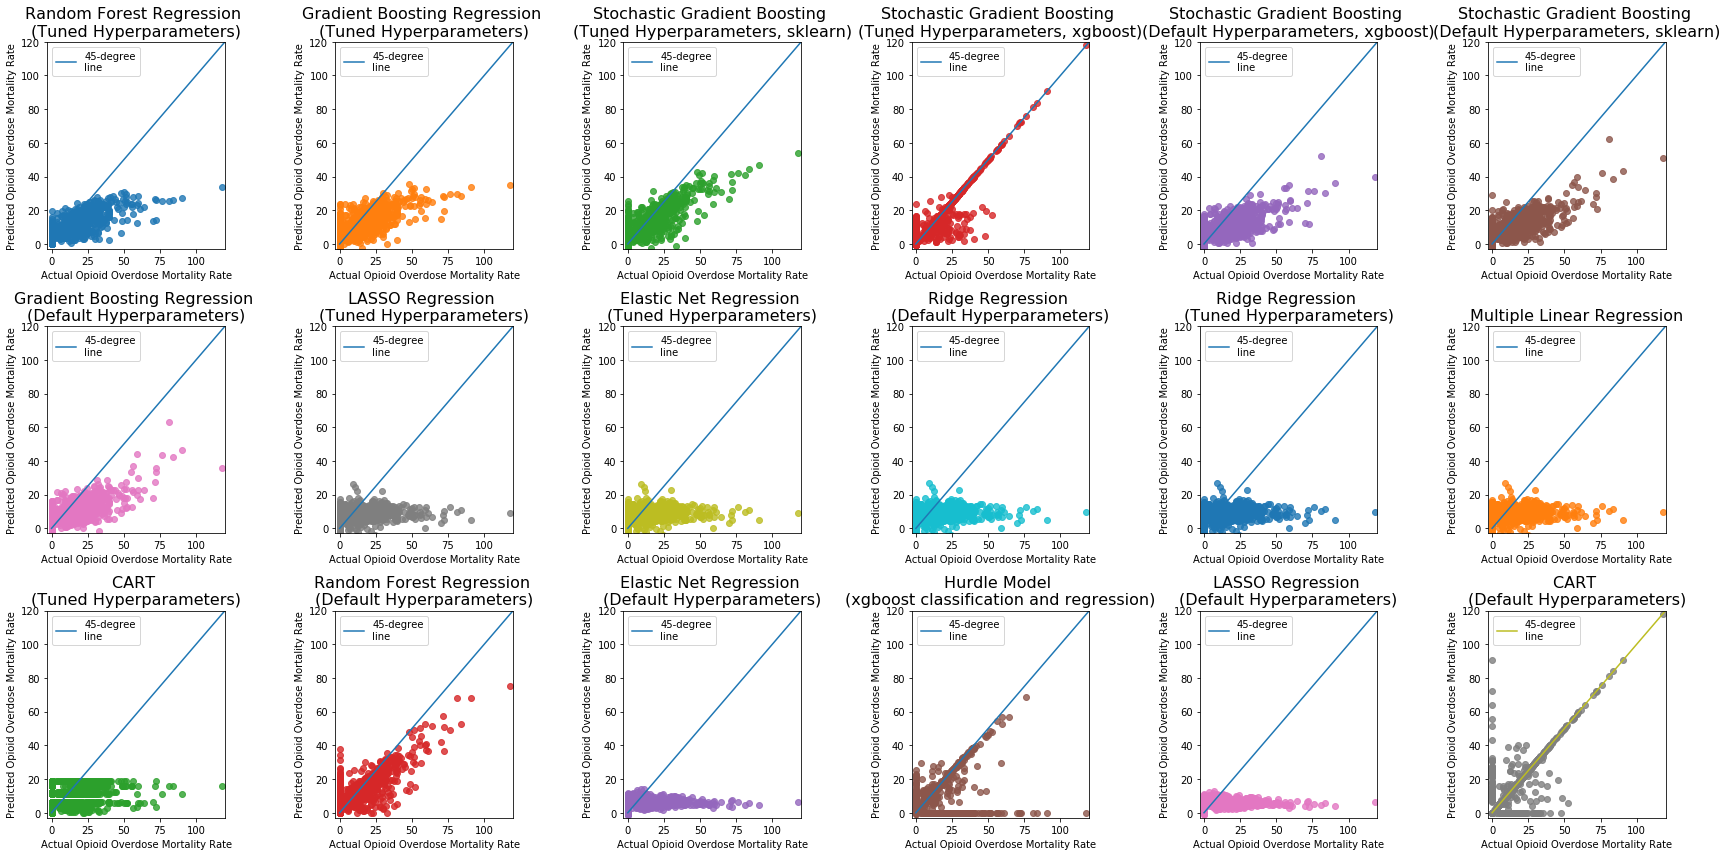

In [52]:
fig, axes = plt.subplots(nrows = 3, ncols = 6, figsize = (24, 12))

for i, ax in enumerate(axes.flatten()):

    _ = sns.regplot(y = predictions_df_reordered.iloc[:, i], x = y, fit_reg = False, ax = ax)
    _ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
    _ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
    if '(' in predictions_df_reordered.columns[i]:
        plot_title = predictions_df_reordered.columns[i].split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]), fontsize = 16)
    else:
        plot_title = predictions_df_reordered.columns[i]
        _ = ax.set_title('{}'.format(plot_title), fontsize = 16)
    _ = ax.plot([0, 120], [0, 120]) # 45 degree line
    _ = ax.legend(['45-degree\nline'], frameon = True)
    _ = ax.set_xlim((-3, 120))
    _ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/predicted_actual_regression_all.png')
fig.show()

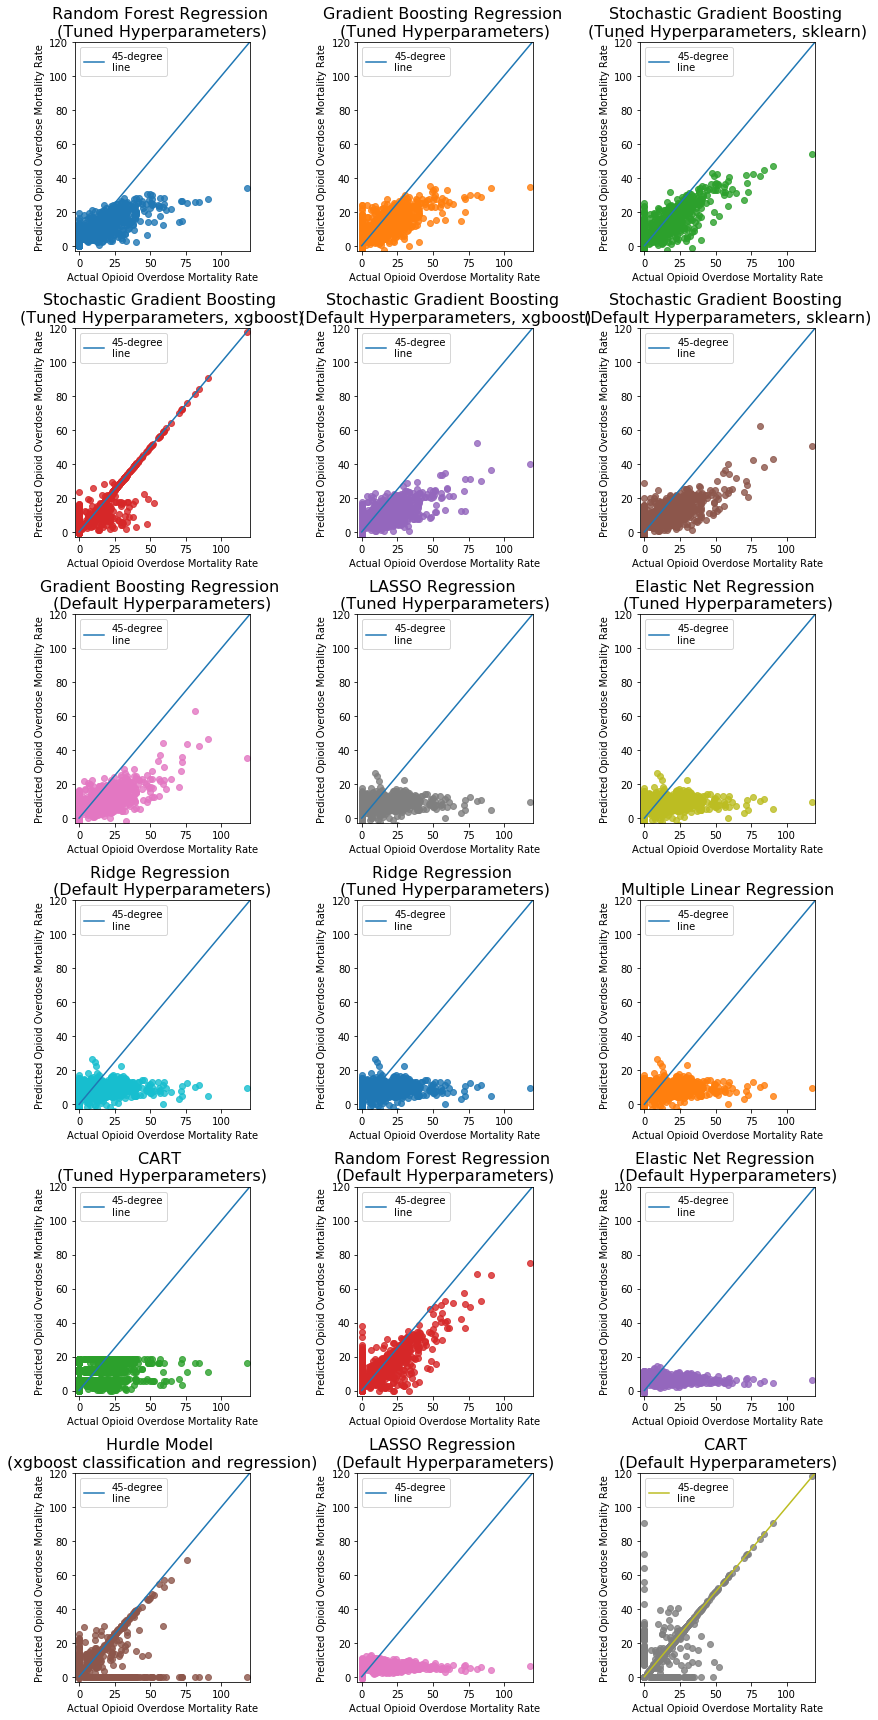

In [49]:
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 24))

for i, ax in enumerate(axes.flatten()):

    _ = sns.regplot(y = predictions_df_reordered.iloc[:, i], x = y, fit_reg = False, ax = ax)
    _ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
    _ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
    if '(' in predictions_df_reordered.columns[i]:
        plot_title = predictions_df_reordered.columns[i].split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]), fontsize = 16)
    else:
        plot_title = predictions_df_reordered.columns[i]
        _ = ax.set_title('{}'.format(plot_title), fontsize = 16)
    _ = ax.plot([0, 120], [0, 120]) # 45 degree line
    _ = ax.legend(['45-degree\nline'], frameon = True)
    _ = ax.set_xlim((-3, 120))
    _ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/predicted_actual_regression_all_blog.png')
fig.show()

In [69]:
y_pred_best_overall_model = predictions_df_reordered.iloc[:, 0]

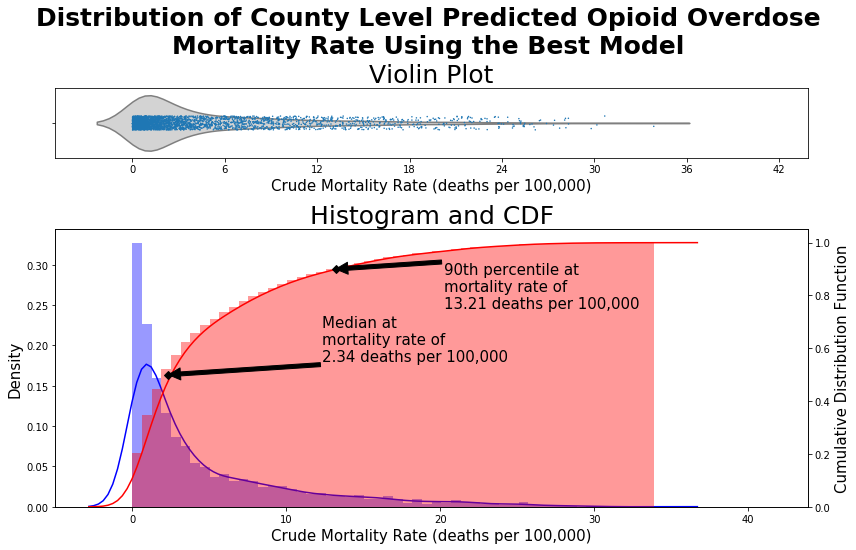

In [70]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(y_pred_best_overall_model)
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.2, .8)}, figsize = (12, 8))

# Add violinplot to first subplot
sns.violinplot(y_pred_best_overall_model, inner = None, color = 'lightgray', ax = ax_box)
sns.stripplot(y_pred_best_overall_model, size = 1.5, jitter = True, ax = ax_box)

# Set x-axis name for the violinplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((min(y_pred_best_overall_model) - 5, max(y_pred_best_overall_model) + 10))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for violinplot
ax_box.set_title("Violin Plot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(y_pred_best_overall_model, color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(y_pred_best_overall_model, 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(y_pred_best_overall_model, 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(round(median, 2)), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(y_pred_best_overall_model, 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((min(y_pred_best_overall_model) - 5, max(y_pred_best_overall_model) + 10))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Predicted Opioid Overdose\nMortality Rate Using the Best Model', 
           fontsize = 25, fontweight = 'bold')

# Adjust plot layout
f.tight_layout(rect = [0, 0.03, 1, 0.9])
f.show()

In [71]:
merged_data = pd.read_csv('merged_data.csv')

In [72]:
merged_data.shape

(2962, 39)

In [73]:
merged_data['Predicted Mortality Rate'] = y_pred_best_overall_model

In [74]:
merged_data['Predicted Mortality Rate'].describe()

count    2962.000000
mean        4.743398
std         5.726829
min         0.000000
25%         0.795531
50%         2.339990
75%         6.745635
max        33.859302
Name: Predicted Mortality Rate, dtype: float64

In [75]:
merged_data.head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,5_9_years_%,60_64_years__%,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,Predicted Mortality Rate
0,1001,55416.0,0.0,AL,129.6,14.0,440.0,455.0,12.096335,0.272440,...,6.620832,5.557962,4.805471,3.847264,2.869207,1.894760,1.311895,1.131442,Autauga,6.080032
1,1003,208563.0,8.6,AL,123.8,12.0,4646.0,2275.0,11.267825,0.823643,...,5.957912,6.897676,6.769178,5.161510,3.553363,2.250639,1.973504,1.097510,Baldwin,7.977683
2,1005,25965.0,0.0,AL,92.7,30.0,-490.0,2977.0,10.453899,-0.192167,...,6.204506,6.339303,6.192952,4.698633,3.158097,2.183709,1.783170,0.955132,Barbour,0.820683
3,1007,22643.0,0.0,AL,97.2,20.0,72.0,2201.0,12.833562,0.885073,...,5.546968,5.895862,5.383562,3.833414,2.976637,1.815131,1.422073,1.157090,Bibb,1.705007
4,1009,57704.0,0.0,AL,56.9,14.0,-28.0,489.0,11.723635,1.076838,...,6.476154,6.372175,6.094898,4.737973,3.292666,2.181824,1.679260,1.147234,Blount,2.826011


In [76]:
merged_data.loc[:, ].sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,5_9_years_%,60_64_years__%,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,Predicted Mortality Rate
989,21097,18646.0,118.0,KY,96.3,15.0,-48.0,275.0,12.142704,1.128304,...,5.985198,6.843291,5.926204,3.984769,3.207122,2.091601,1.791269,1.190604,Harrison,33.859302
2819,54011,95987.0,90.6,WV,122.3,22.0,-793.0,4077.0,11.065367,0.718260,...,5.530957,6.246679,5.939346,4.110973,3.100420,2.286768,2.275308,1.177243,Cabell,27.346762
2863,54099,40531.0,83.9,WV,67.5,22.0,-507.0,246.0,9.942956,0.000000,...,5.719079,6.965039,6.807135,4.746984,3.508426,2.304409,2.193383,0.994301,Wayne,25.954292
2843,54059,24647.0,81.1,WV,96.5,28.0,-601.0,85.0,11.810630,0.000000,...,6.061590,7.883312,6.816245,3.874711,2.844160,1.858238,1.432223,1.294275,Mingo,25.448025
1162,24510,614664.0,76.1,MD,54.6,22.0,-6073.0,26089.0,13.672702,3.695194,...,5.986035,5.764125,4.671821,2.934449,2.104727,1.504074,1.652285,1.384822,Baltimore City,25.207842


In [77]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head(20)

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
989,Harrison,KY,118.0,33.859302
2819,Cabell,WV,90.6,27.346762
2863,Wayne,WV,83.9,25.954292
2843,Mingo,WV,81.1,25.448025
1162,Baltimore City,MD,76.1,25.207842
1716,Rio Arriba,NM,72.4,14.292769
2815,Berkeley,WV,72.2,26.080752
724,Scott,IN,71.6,26.432152
1137,Washington,ME,70.0,13.827579
981,Grant,KY,64.2,21.668540


In [78]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
2433,Comanche,TX,0.0,0.0
1335,Todd,MN,0.0,0.0
1588,Burt,NE,0.0,0.0
808,Mitchell,IA,0.0,0.0
864,Elk,KS,0.0,0.0


In [79]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
0,Autauga,AL,0.0,6.080032
1796,Bertie,NC,0.0,1.736883
1797,Bladen,NC,0.0,1.625949
1804,Caswell,NC,0.0,1.200819
1806,Chatham,NC,0.0,5.157428


In [80]:
# overall mse using best model
np.sqrt(np.mean((y - y_pred_best_overall_model)**2))

6.836232143564332

# Feature Importance Based on Best Models

In [89]:
# create a list of models (excluding hurdle model)
models_lst = [linear_pipeline, 
              ridge_pipeline, 
              best_model_ridge, 
              lasso_pipeline, 
              best_model_lasso, 
              enet_pipeline, 
              best_model_enet, 
              dt,
              best_model_dt,
              rf,
              best_model_rf,
              gb,
              best_model_gb,
              sgbr,
              best_model_sgb,
              xgbr,
              best_model_xgbr]

In [90]:
# create labels for models (excluding hurdle model)
model_labels = bootstrap_rmse_df.columns[:-1]

#  
model_dict = dict(zip(model_labels, models_lst))

In [91]:
model_dict_ordered = collections.OrderedDict()

In [94]:
for column in [column for column in bootstrap_rmse_df_reverse.columns if 'Hurdle' not in column]:
    model_dict_ordered['{}'.format(column)] = model_dict[column]

In [95]:
model_dict_ordered_keys_list = list(model_dict_ordered.keys())
model_dict_ordered_items_list = list(model_dict_ordered.items())

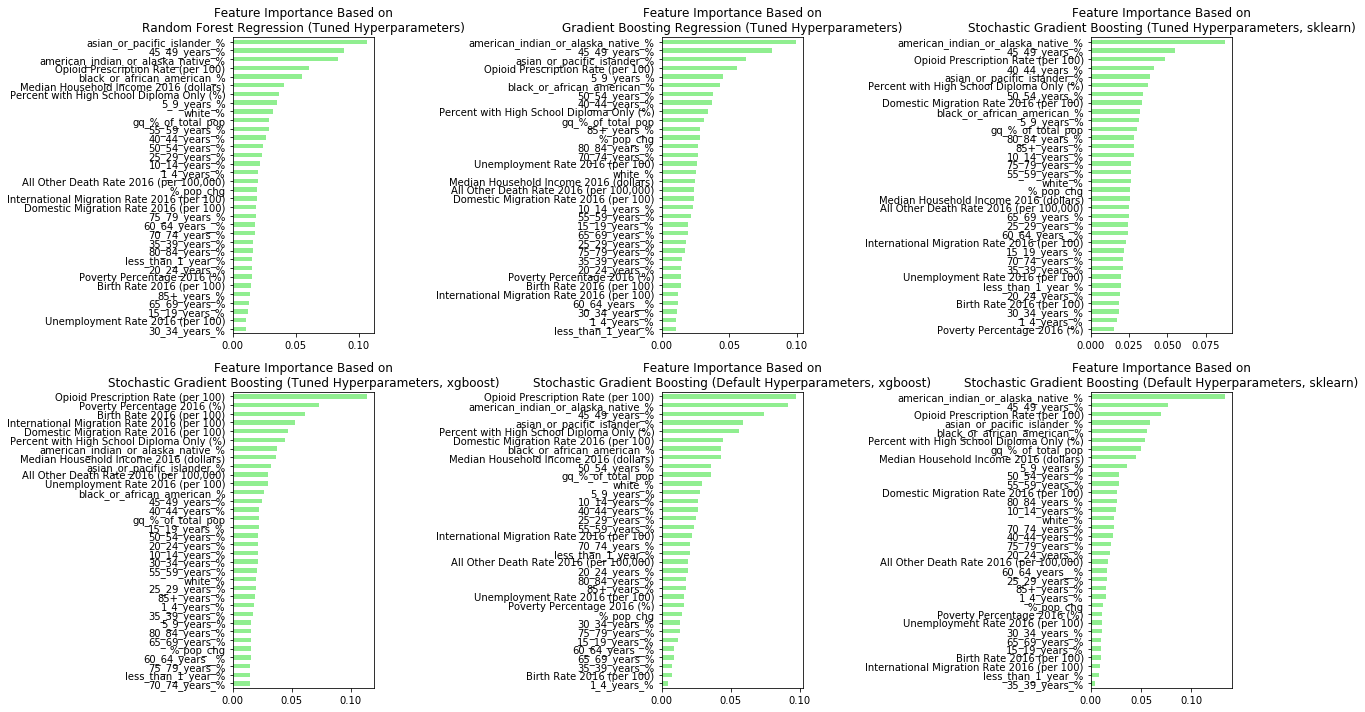

In [96]:
f, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 10))

for i, ax in enumerate(axes.flatten()):
    if 'Default' in model_dict_ordered_keys_list[i]:
        # create a pd.Series of features importances
        feature_importances = pd.Series(model_dict_ordered_items_list[i][1].feature_importances_, index = X.columns)
    else:
        feature_importances = pd.Series(model_dict_ordered_items_list[i][1].steps[0][1].feature_importances_, index = X.columns)
        
    # sort feature_importances
    sorted_importances = feature_importances.sort_values()

    # make a horizontal bar plot
    sorted_importances.plot(kind = 'barh', color = 'lightgreen', ax=ax)
    ax.set_title('{}'.format(model_dict_ordered_keys_list[i]))
f.tight_layout()
# f.savefig('images/feature_importances.png')
f.show()

# Conclusion from Prediction Analysis

After considering the prediction analysis, I recommend XGBoost's stochastic gradient boosting model with tuned hyperparameters as the model to use to make predictions. Even though XGBoost's stochastic gradient boosting model was the fourth best performing model, the difference in the RMSE means between this model and the best performing model is not very different practically. XGBoost's stochastic gradient boosting model seems to make the best fitting predictions based on the scatterplots above. 

We have now obtained a tool that we can use to predict a county's opioid overdose mortality rate given 36 variables about the county. This tool is useful for the following reasons:

1. Once we predict a county's opioid overdose mortality rate, we can then focus on the counties that are predicted to have high opioid overdose mortality rate. This will help us more efficiently allocate resources to combat this epidemic.
2. By focusing on the counties that are predicted to have high opioid overdose mortality rates, we can better investigate the cause of opioid addition. Once we find a cause, we can more effectively combat this epidemic.
3. We can predict the change in opioid overdose mortality rate when some of the predictor variable values change.

There is also one finding that is quite surprising. There is no one predictor variable that contribute overwhelmingly to opioid overdose mortality rate. Poverty rate, median household income, and unemployment rates are not the most important predictors in opioid overdose mortality rate. Instead, what we find are variables like the following:

1. **american_indian_or_alaska\_native\_%**
* **asian_or_pacific\_islander\_%**
* **45_49\_years\_%**
* **Opioid Prescription Rate (per 100)**

**Opioid Prescription Rate (per 100)** seems to make sense in that higher **Opioid Prescription Rate (per 100)** would lead to higher opioid overdose mortality rate. However, it is surprising to see the other three predictor variables as being the top features in predicting opioid overdose mortality rate.

# Further Research

Findings from this data analysis can be used to investigate some causes of opioid addiction and opioid overdose mortality rate. Further investigation should also be done to see why **american_indian_or_alaska\_native\_%**, **asian_or_pacific\_islander\_%**, and **45_49\_years\_%** play an important role in predicting opioid overdose mortality rate.